In [1]:
import re
from tqdm import tqdm
#import pickle
#import matplotlib.colors as mplc
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#from textblob import TextBlob
pd.set_option('display.max_colwidth', None)

# Cleaning

In [2]:
train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

In [3]:
# df = pd.concat([train_df, test_df])
# df = df.reset_index(drop=True)
df = train_df
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
def remove_urls(text: str, replacement: str="") -> str:
    """Removes URLs from a given string."""
    """Also removes @ mentions."""
    # Define the regex used to identify URLs
    url_expression = (
        r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)"
        r"(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s("
        r")<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    )
    # Replace any URLs with the replacement string
    text1 = re.sub(url_expression, replacement, text)
    
    #remove @ mentions and return
    return re.sub(r"@[A-Za-z0-9]+", replacement, text1)

In [5]:
def remove_nonalphanumeric(text: np.str_) -> str:
    """
    Removes non-alphanumeric characters from a given string.
    
    Preserves spaces and quotation marks (to preserve contractions).
    """

    return re.sub("[^A-Za-z0-9 '\"]+", '', text)

In [6]:
df["text"] = df["text"].apply(remove_urls) # Must be done first
df["text"] = df["text"].apply(remove_nonalphanumeric)

In [7]:
#remove irrelevant string
df['text'] = df.text.str.replace('I liked a YouTube video', '').replace('I added a video to a YouTube playlist', '')

In [8]:
df['text_lower'] = df.text.str.lower()

In [9]:
#removing duplicate tweets
df = df.drop_duplicates(subset=['text_lower'], keep='first')
df = df.reset_index(drop=True)

In [10]:
df.head()

,id,keyword,location,text,target,text_lower
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1,all residents asked to 'shelter in place' are being notified by officers no other evacuation or shelter in place orders are expected
3,6,NaN,NaN,13000 people receive wildfires evacuation orders in California,1,13000 people receive wildfires evacuation orders in california
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


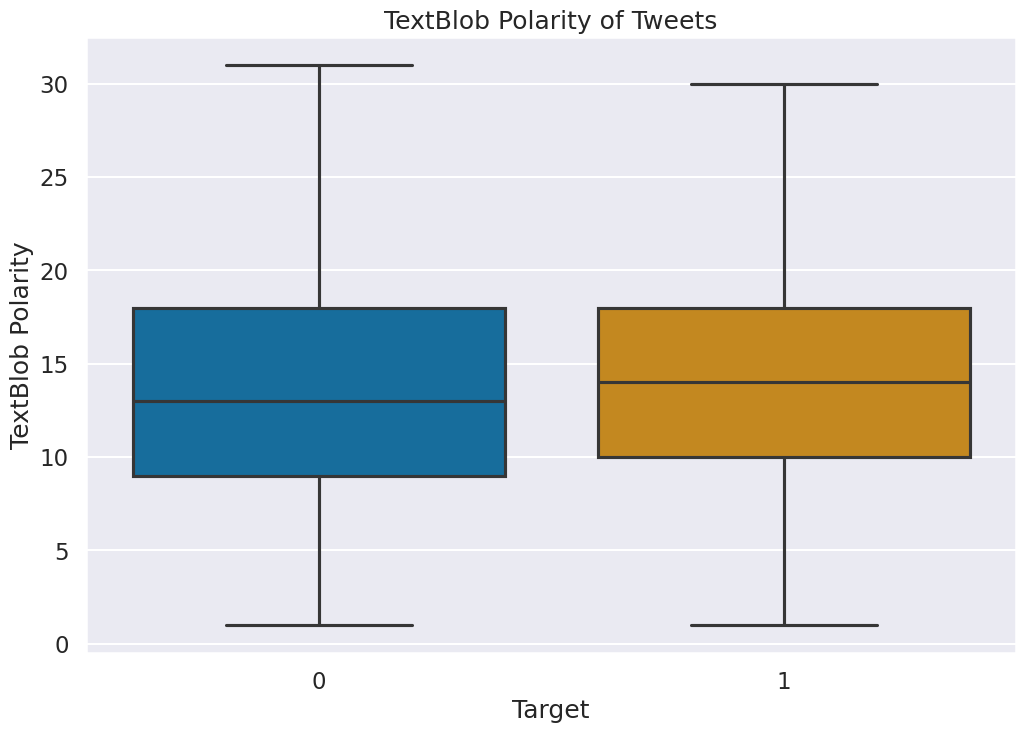

In [60]:
df['word_count'] = [len(i) for i in df.text.str.split()]

#sns.set_context("talk")

sns.boxplot(x='target', y='word_count', data=df, fliersize=1).set(
    title='TextBlob Polarity of Tweets',
    xlabel='Target',
    ylabel='TextBlob Polarity',
)

# plt.savefig("TextBlob Polarity.png",
#                   bbox_inches="tight",
#                   dpi = 400)

plt.show()

# Lemmatize

In [12]:
#!python -m spacy download en_core_web_sm

In [13]:
nlp = spacy.load('en_core_web_sm')
                 #, disable=['parser'])

nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [14]:
#remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [15]:
#Customize stop words

#stopwords = nlp.Defaults.stop_words

# print(len(stopwords))

# #add new stop words
# nlp.Defaults.stop_words.add("my_new_stopword")
#nlp.Defaults.stop_words |= {"Afham","Farden"}

# #remove stop words
# nlp.Defaults.stop_words.remove("what")
# nlp.Defaults.stop_words -= {"who", "when"}

# # My custom list of stop words.
stop_list = ["like"]
# # Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [16]:
'like' in nlp.Defaults.stop_words

True

In [17]:
#remove stop word, lemmatization
def preprocess(doc):

    sent_cleaned = ''
    for token in nlp(doc):
        if not token.is_stop:
            if not token.pos_ == 'PUNCT':
                sent_cleaned += token.lemma_.lower()
                sent_cleaned += ' '
    sent_cleaned = sent_cleaned.strip()
    return sent_cleaned

In [18]:
#remove stop word, lemmatization
# processed = tqdm(tweets_df_en['CleanedText'].\
#         map(lambda x: preprocess(x)))
#         #map(lambda x: spellchecker(x)).\ not including spellchecker since it changes Elon to Leon
processed=[]
for tweet in tqdm(df['text']):
    processed.append(preprocess(tweet))

100%|██████████████████████████████████████████████████████████████████████████████| 6923/6923 [00:23<00:00, 296.30it/s]


In [19]:
len(processed)

6923

# TF-IDF Tokenize

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [21]:
#TF-IDF
#limit max features for performance
tv = TfidfVectorizer(stop_words=None, ngram_range=(1,2), max_features=10000)
tv_out = tv.fit_transform(processed)

In [22]:
tfidf = pd.DataFrame(tv_out.toarray(), columns=tv.get_feature_names())

/home/josh_wang/anaconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
tfidf.head(5)

,001116,001116 utc20150805,005225,005225 utc20150805,0104,010401,010401 utc20150805,015025,02,0306,...,zionism,zionist,zionist terrorist,zip,zippednews,zombie,zombie apocalypse,zone,zouma,zouma flatten
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# NMF

In [24]:
from sklearn.decomposition import NMF, TruncatedSVD

In [25]:
nmf = NMF(5, init = "nndsvda")
nmf.fit(tfidf)

NMF(init='nndsvda', n_components=5)

In [26]:
# #saving nmf
# with open('fitted_nmf.pkl', 'wb') as handle:
#     pickle.dump(nmf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
topic_term = nmf.components_.round(3)

topic_term_df = pd.DataFrame(topic_term.round(3),
                index = ["component_1", "component_2", "component_3", "component_4", "component_5"],
                columns = tv.get_feature_names())

/home/josh_wang/anaconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
topic_term_df

,001116,001116 utc20150805,005225,005225 utc20150805,0104,010401,010401 utc20150805,015025,02,0306,...,zionism,zionist,zionist terrorist,zip,zippednews,zombie,zombie apocalypse,zone,zouma,zouma flatten
component_1,0.001,0.001,0.000,0.000,0.001,0.001,0.001,0.000,0.008,0.001,...,0.001,0.006,0.003,0.002,0.002,0.018,0.007,0.081,0.004,0.002
component_2,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.002,0.000,0.000,...,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000
component_3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,...,0.000,0.000,0.000,0.028,0.000,0.007,0.000,0.000,0.000,0.000
component_4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.017,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000


In [29]:
# Function to display the top n terms in each topic
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [30]:
output = display_topics(nmf, tv.get_feature_names(), 8)
output;


Topic  1
go, amp, get, know, bomb, think, look, come

Topic  2
fire, forest, wild, forest fire, truck, california, wild fire, bush

Topic  3
body, bag, body bag, cross, cross body, meek, drake, shoulder

Topic  4
scream, love, loud, hear, ass, bang, loud bang, hear loud

Topic  5
burn, building, burn building, fire burn, crash, run, run burn, crash burn




/home/josh_wang/anaconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
#mapping topics to each tweet
doc_topic_nmf = nmf.transform(tfidf)

In [32]:
doc_topic_nmf_df = pd.DataFrame(doc_topic_nmf.round(5), columns = ["unknown1", 
                                                                   "california wildfire", 
                                                                   'unknown2', 
                                                                   'loud scream',
                                                                   'burn building'])
doc_topic_nmf_df['Text'] = df['text']
doc_topic_nmf_df.head()

,unknown1,california wildfire,unknown2,loud scream,burn building,Text
0,0.00686,0.00000,0.00000,0.00000,0.00000,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1,0.00000,0.16894,0.00000,0.00000,0.00000,Forest fire near La Ronge Sask Canada
2,0.00845,0.00281,0.00029,0.00014,0.00000,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected
3,0.01118,0.02685,0.00000,0.00000,0.00768,13000 people receive wildfires evacuation orders in California
4,0.02386,0.01025,0.00173,0.00000,0.01078,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school


In [33]:
doc_topic_nmf_df.sort_values('loud scream', ascending = False).head(10)

,unknown1,california wildfire,unknown2,loud scream,burn building,Text
5462,0.00000,0.0,0.00000,0.50041,0.0,Screams
5430,0.00000,0.0,0.00000,0.50041,0.0,screams 666
5445,0.00000,0.0,0.00000,0.50041,0.0,screams
5422,0.00000,0.0,0.00000,0.50041,0.0,SCREAMING
5435,0.00000,0.0,0.00000,0.50041,0.0,screams
5442,0.00000,0.0,0.00000,0.50041,0.0,Still echoes of their screams
5418,0.00326,0.0,0.00000,0.42948,0.0,All the loves be screaming at this one
5385,0.00000,0.0,0.00000,0.38892,0.0,I have never screamed so loud
5390,0.00000,0.0,0.00387,0.35891,0.0,I just screamed what the fuck is a hond
5415,0.00000,0.0,0.00000,0.32731,0.0,I'M SCREAMING OMG IDOLS 22DAYS WDYM


# LSA

In [34]:
lsa = TruncatedSVD(5)
doc_topic_lsa = lsa.fit_transform(tfidf)
lsa.explained_variance_ratio_

array([0.00153433, 0.00297538, 0.00282585, 0.00251199, 0.00243883])

In [35]:
# #saving lsa
# with open('fitted_lsa.pkl', 'wb') as handle:
#     pickle.dump(lsa, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tv.get_feature_names())
topic_word

/home/josh_wang/anaconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,001116,001116 utc20150805,005225,005225 utc20150805,0104,010401,010401 utc20150805,015025,02,0306,...,zionism,zionist,zionist terrorist,zip,zippednews,zombie,zombie apocalypse,zone,zouma,zouma flatten
component_1,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.002,0.0,...,0.002,0.001,0.001,0.003,0.001,0.005,0.002,0.017,0.001,0.0
component_2,-0.000,-0.000,0.0,0.0,0.0,0.0,0.0,0.001,-0.002,-0.0,...,0.001,-0.001,-0.001,-0.006,0.000,-0.005,-0.001,-0.018,-0.001,-0.0
component_3,-0.000,-0.000,-0.0,-0.0,-0.0,-0.0,-0.0,0.000,-0.001,-0.0,...,-0.000,-0.001,-0.000,0.012,-0.000,0.001,-0.001,-0.012,-0.001,-0.0
component_4,-0.001,-0.001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,0.000,-0.0,...,-0.001,-0.001,-0.001,-0.001,0.000,0.000,0.000,-0.009,-0.001,-0.0
component_5,-0.000,-0.000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,0.002,-0.0,...,-0.005,0.001,0.000,0.001,-0.000,-0.000,0.000,-0.002,-0.000,-0.0


In [37]:
display_topics(lsa, tv.get_feature_names(), 8);


Topic  1
fire, burn, amp, go, building, get, know, come

Topic  2
fire, burn, building, forest, forest fire, wild, truck, california

Topic  3
body, bag, body bag, fire, cross body, cross, meek, shoulder

Topic  4
scream, love, wreck, crush, loud, hear, video, think

Topic  5
wreck, fire, go, loud, news, hear, bang, loud bang




/home/josh_wang/anaconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
doc_topic_lsa_df = pd.DataFrame(doc_topic_lsa.round(5), columns = ["fire burn", 
                                                                   "california fire", 
                                                                   'unknown', 
                                                                   'loud scream',
                                                                  'burn/suicide bomber'])
doc_topic_lsa_df['Text'] = df['text']
doc_topic_lsa_df.head()

,fire burn,california fire,unknown,loud scream,burn/suicide bomber,Text
0,0.01418,-0.00877,-0.00879,-0.00384,-0.00306,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1,0.17110,0.24452,0.06475,-0.00330,0.08302,Forest fire near La Ronge Sask Canada
2,0.02294,-0.00648,-0.00680,-0.00396,0.00689,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected
3,0.06284,0.02696,-0.00596,-0.00892,0.00746,13000 people receive wildfires evacuation orders in California
4,0.07737,-0.00769,-0.01742,-0.00431,-0.01360,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school


In [39]:
doc_topic_lsa_df.sort_values('unknown', ascending = False).head(10)

,fire burn,california fire,unknown,loud scream,burn/suicide bomber,Text
955,0.15240,-0.35040,0.84361,-0.02015,-0.03777,body bags
910,0.15240,-0.35040,0.84361,-0.02015,-0.03777,G Body Bagging them lyrically
927,0.14139,-0.30298,0.72001,-0.01785,-0.03396,Has body bagged RT lac Drake is body bagging meek
930,0.20938,-0.33058,0.66535,-0.00515,0.03320,I was going to tell him but you were body bagging him
908,0.11690,-0.26719,0.64087,-0.01486,-0.02873,body bagging mfs
909,0.13637,-0.27696,0.63335,-0.01361,-0.02566,I skimmed through twitter and missed this body bagging
951,0.12267,-0.25521,0.60100,-0.01437,-0.02393,bring the body bags tho
942,0.11570,-0.25642,0.59623,0.01032,0.02904,Appears to already be arriving in Ridah in body bags
915,0.11645,-0.25603,0.59253,-0.01807,-0.02718,I was body Bagging on the Today4got to post my score
900,0.12770,-0.25994,0.59037,-0.01382,-0.02881,Nuu that FAM fwt I'm Leave You In a Body bag


# LDA
Bad interpretability

In [40]:
from gensim import corpora, models, matutils

In [41]:
tv_term_doc=tv_out.transpose()
corpus = matutils.Sparse2Corpus(tv_term_doc)

id2word = dict((v, k) for k, v in tv.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10)

In [42]:
lda.print_topics()

[(0,
  '0.009*"wreck" + 0.005*"trauma" + 0.004*"wildfire" + 0.003*"panic" + 0.003*"typhoon" + 0.003*"siren" + 0.003*"fire" + 0.003*"lightning" + 0.003*"cause" + 0.002*"beautiful"'),
 (1,
  '0.009*"thunder" + 0.006*"tornado" + 0.004*"zone" + 0.004*"war zone" + 0.004*"sink" + 0.004*"war" + 0.003*"go" + 0.003*"trap" + 0.003*"flood" + 0.003*"traumatised"'),
 (2,
  '0.010*"weapon" + 0.005*"wound" + 0.004*"drown" + 0.003*"nuclear" + 0.003*"earthquake" + 0.003*"thunderstorm" + 0.003*"severe" + 0.003*"windstorm" + 0.003*"storm" + 0.003*"volcano"'),
 (3,
  '0.005*"tragedy" + 0.004*"traumatise" + 0.004*"fire" + 0.003*"wild" + 0.003*"disaster" + 0.003*"wild fire" + 0.003*"rescue" + 0.003*"evacuate" + 0.002*"natural" + 0.002*"get"'),
 (4,
  '0.004*"survive" + 0.004*"terrorism" + 0.003*"mass" + 0.003*"suicide" + 0.003*"body" + 0.003*"wreck" + 0.003*"scream" + 0.003*"watch" + 0.003*"look" + 0.002*"hostage"')]

Topics are nonsensical... Abandon.

In [43]:
# #turn topic 0 result to data frame
# x = lda.show_topics()
# for tp in x[:1]:
#     biglist=[]
#     for i in tp[1].split('+'):
#         biglist.append([k.strip().strip('"') for k in i.split('*')])

# topic0df = pd.DataFrame(biglist)
# topic0df

In [44]:
doc_topic = [doc for doc in lda[corpus]]

In [45]:
doc_topic_clean=[]
for doc in doc_topic:
    doc_topic_clean.append([topic[1] for topic in doc])

In [46]:
doc_topic_df = pd.DataFrame(doc_topic_clean, columns = ["volcano/terrorism?", 
                                                       "weapon/wildfire?", 
                                                       'tragegy/wreck?', 
                                                       'tornado?',
                                                      'storm?'])
doc_topic_df.head()

,volcano/terrorism?,weapon/wildfire?,tragegy/wreck?,tornado?,storm?
0,0.062278,0.062442,0.750795,0.062245,0.062241
1,0.057353,0.774523,0.055766,0.056416,0.055941
2,0.739147,0.049750,0.111148,0.050245,0.049710
3,0.795764,0.051125,0.051006,0.051036,0.051069
4,0.781319,0.053720,0.053790,0.057700,0.053469


In [47]:
doc_topic_df['Text'] = df['text']

In [48]:
doc_topic_df.head()

,volcano/terrorism?,weapon/wildfire?,tragegy/wreck?,tornado?,storm?,Text
0,0.062278,0.062442,0.750795,0.062245,0.062241,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1,0.057353,0.774523,0.055766,0.056416,0.055941,Forest fire near La Ronge Sask Canada
2,0.739147,0.049750,0.111148,0.050245,0.049710,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected
3,0.795764,0.051125,0.051006,0.051036,0.051069,13000 people receive wildfires evacuation orders in California
4,0.781319,0.053720,0.053790,0.057700,0.053469,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school


# Topic Visualization (NMF)

In [49]:
doc_topic_nmf_df['target'] = df['target']
doc_topic_nmf_df.head()

,unknown1,california wildfire,unknown2,loud scream,burn building,Text,target
0,0.00686,0.00000,0.00000,0.00000,0.00000,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,0.00000,0.16894,0.00000,0.00000,0.00000,Forest fire near La Ronge Sask Canada,1
2,0.00845,0.00281,0.00029,0.00014,0.00000,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1
3,0.01118,0.02685,0.00000,0.00000,0.00768,13000 people receive wildfires evacuation orders in California,1
4,0.02386,0.01025,0.00173,0.00000,0.01078,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1


In [50]:
topic_df_nmf = doc_topic_nmf_df.groupby('target')[["unknown1", 
                                           "california wildfire", 
                                           'unknown2', 
                                           'loud scream',
                                           'burn building']].mean()

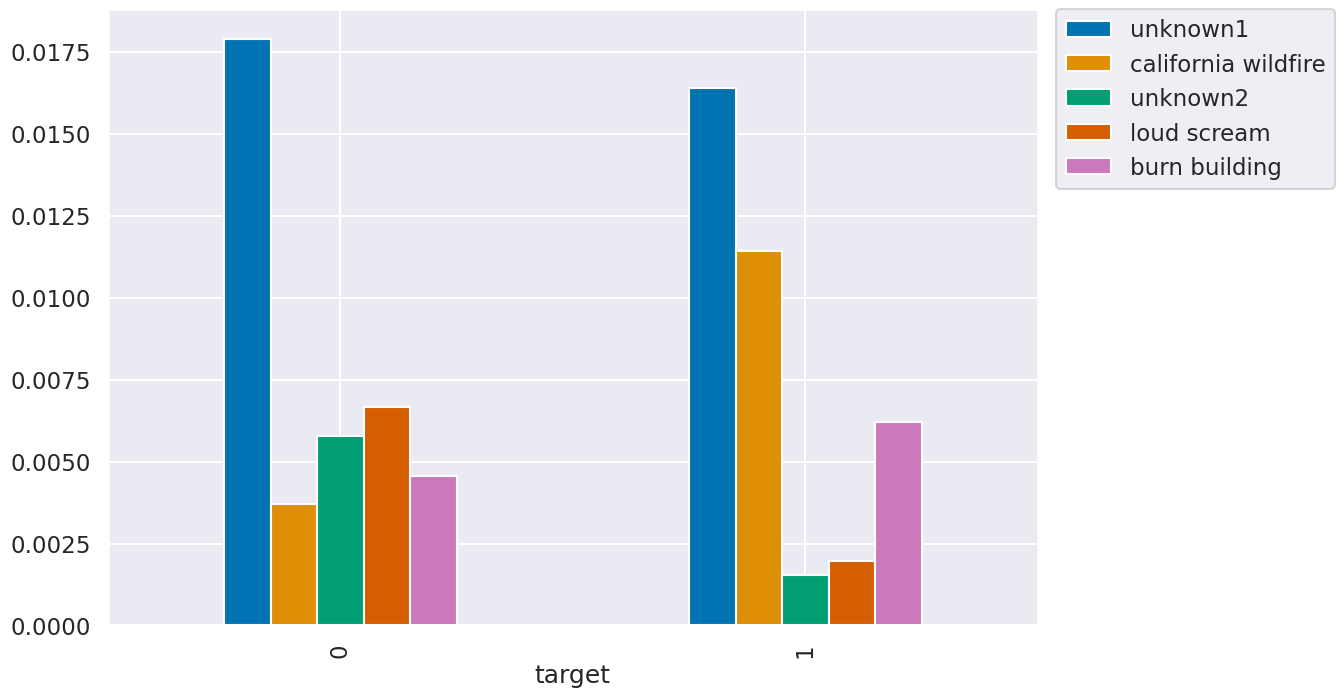

In [55]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_context("talk")
sns.set_palette(sns.color_palette(palette='colorblind'))
ax = topic_df_nmf.plot(kind="bar")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax.figure.savefig("topic_NMF.png",
                  bbox_inches="tight",
                  dpi = 400)
plt.show()

# Topic Visualization (LSA)

In [52]:
doc_topic_lsa_df['target'] = df['target'] 
doc_topic_lsa_df.head()

,fire burn,california fire,unknown,loud scream,burn/suicide bomber,Text,target
0,0.01418,-0.00877,-0.00879,-0.00384,-0.00306,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,0.17110,0.24452,0.06475,-0.00330,0.08302,Forest fire near La Ronge Sask Canada,1
2,0.02294,-0.00648,-0.00680,-0.00396,0.00689,All residents asked to 'shelter in place' are being notified by officers No other evacuation or shelter in place orders are expected,1
3,0.06284,0.02696,-0.00596,-0.00892,0.00746,13000 people receive wildfires evacuation orders in California,1
4,0.07737,-0.00769,-0.01742,-0.00431,-0.01360,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1


In [53]:
topic_df = doc_topic_lsa_df.groupby('target')[["fire burn", 
                                           "california fire", 
                                           'unknown', 
                                           'loud scream',
                                          'burn/suicide bomber']].mean()

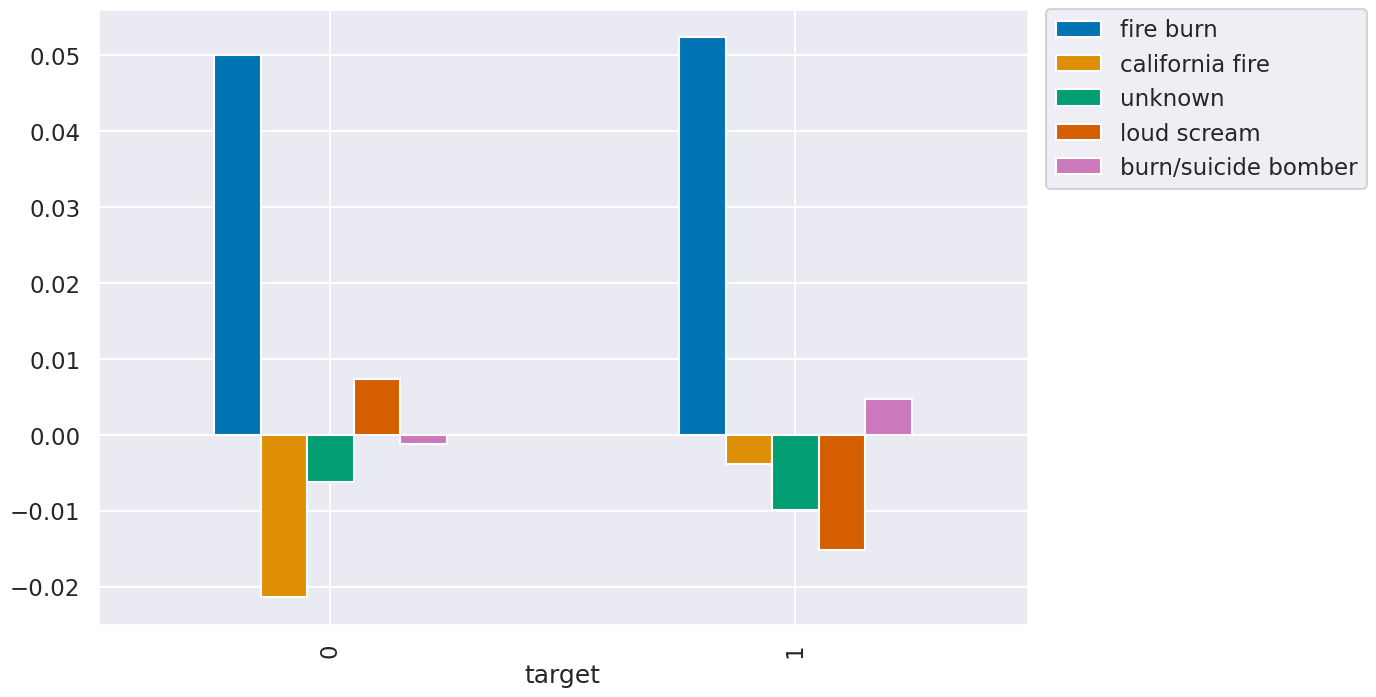

In [54]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_context("talk")
sns.set_palette(sns.color_palette(palette='colorblind'))
ax = topic_df.plot(kind="bar")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# ax.figure.savefig("topic_LSA.png",
#                       bbox_inches="tight")
plt.show()